In [1]:
from cffi import FFI
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from cffi import FFI
ffibuilder = FFI()

ffibuilder.set_source("_goertzel",
   r""" // passed to the real C compiler,
        // contains implementation of things declared in cdef()
        #include <math.h>

        // We can also define custom wrappers or other functions
        // here (this is an example only):
        double test_cos(double x) {
            return cos(x);
        }
        #define RING_SIZE 512
        
        void sg_block(int32_t *x, int offset, double* z, double *Pxx, double c) {
            int block_size = 64;
            int window_size = 256; 
            // Do index math just once... 
            int32_t *curr = x+offset;
            int32_t *past = x + ((offset - window_size) & (RING_SIZE-1));
            double z0;
            double z1 = z[0];
            double z2 = z[1];
            
            for (int idx=0; idx<block_size; idx++) {
                // z0 = x[offset + idx] - x[((offset + idx - window_size)&(512-1))] + c*z1 - z2;
                z0 = *curr++ - *past++ + c*z1 - z2;
                z2 = z1;
                z1 = z0;
                Pxx[idx] = z2*z2 + z1*z1 - c * z1*z2;
            }
            z[0] = z1;
            z[1] = z2;
        }
    """,
    libraries=['m'])   # or a list of libraries to link with
    # (more arguments like setup.py's Extension class:
    # include_dirs=[..], extra_objects=[..], and so on)

ffibuilder.cdef("""
    // declarations that are shared between Python and C
    double test_cos(double x);
    void sg_block(int32_t *x, int offset, double* z, double *Pxx, double c);
""")


ffibuilder.compile(verbose=True)


generating ./_goertzel.c
(already up-to-date)
the current directory is '/Users/nams/Documents/projects/gburg-ultrasonic'
running build_ext
building '_goertzel' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include/python3.8 -c _goertzel.c -o ./_goertzel.o
gcc -bundle -undefined dynamic_lookup -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -arch x86_64 ./_goertzel.o -lm -o ./_goertzel.cpython-38-darwin.so


'/Users/nams/Documents/projects/gburg-ultrasonic/_goertzel.cpython-38-darwin.so'

In [3]:
# import compiled c library... used CFFI in API mode
import _goertzel

#  Load data into a binary array
fd = open('single_tone_v2.dat', 'rb')
raw = fd.read()
fd.close()

# Allocated all memory needed to run algorithm
z = np.zeros(2)
ring = np.zeros(512, np.int32)
result = np.zeros(1280000)
Pxx = np.zeros(64)
# Point to the beginning of the ring buffer
write_addr = 0
# Calculate parameters for the goertzel algorithm
k=100; window_size=256
w = 2*np.pi*k/window_size;
c = 2*np.cos(w);

# Get pointers to the addresses in memory for the output and results
ptr_ring = _goertzel.ffi.cast("int32_t *", ring.ctypes.data)
ptr_z = _goertzel.ffi.cast("double *", z.ctypes.data)
ptr_Pxx = _goertzel.ffi.cast("double *", Pxx.ctypes.data)

#
start = time.time()
for count in range(int(len(raw)/4/64)):
    block = np.frombuffer(raw[(count*256):((count+1)*256)], dtype=np.int32)
    block = block >> 14
    if (len(block)==0):
        break
    ring[(write_addr):(write_addr+64)] = block
    _goertzel.lib.sg_block(ptr_ring, write_addr, ptr_z, ptr_Pxx, c)
    write_addr += 64
    write_addr &= (512-1)
    result[count*64:(count+1)*64] = Pxx
print(time.time()-start)

0.14063501358032227


In [4]:
from numba import jit
# Sliding Goertzel block
@jit
def sg_block(x, offset, z1, z2, Pxx, c, block_size=64, k=25*4, window_size=64*4):
    #Pxx = np.zeros[block_size]
    #w = 2*np.pi*k/window_size;
    #c = 2*np.cos(w);
    for idx in range(block_size):
        z0 = x[offset + idx] - x[offset + idx-window_size] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        Pxx[idx] = z2*z2 + z1*z1 - c * z1*z2
    return z1, z2

In [5]:
# Sliding Goertzel
@jit
def sg_v2(x, k=25*4):
    Pxx = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)
    return np.array(Pxx)

In [10]:
raw = np.fromfile('single_tone_v2.dat', dtype=np.int32)
data = raw>>14
start = time.time()
filtered = sg_v2(data, k=100)
print(time.time()-start)

0.02104496955871582


In [7]:
# compare if we get identical answers with known working filter
np.where(filtered-result)

(array([], dtype=int64),)

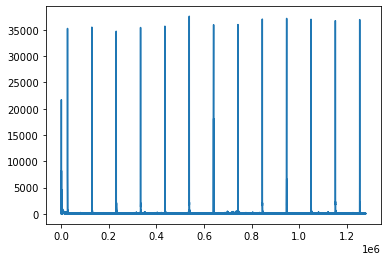

In [8]:
plt.plot((2*result)**0.5)